# Plateforme Agnostique de Traitement et d'Analyse des Textes
### Carnet d'expérimentation
---

## Sujet : Explainability with eli5


---

# Initialisations
---

In [1]:
_rs = 42

In [2]:
cd ../..

/Volumes/Geek/Work/Patat


In [3]:
import ast
import importlib
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
tqdm.pandas()

# Préparation Données

---

## Chargements

In [10]:
import patat.util.file

filename = 'data/prod/230531-Corpus.pickle'

df_corpus = patat.util.file.pickle_load(filename)

In [11]:
stopwords = patat.util.file.pickle_load('data/tmp/stopwords.pickle')

In [14]:
df_fsoir = df_corpus[df_corpus['site']=='www.francesoir.fr']

In [22]:
df_fsoir = df_fsoir[df_fsoir['author'].notna()]

In [23]:
def is_afp(text):
    return 'afp' in text.lower()

In [24]:
df_fsoir['afp']=df_fsoir['author'].apply(is_afp)

<Axes: xlabel='afp', ylabel='count'>

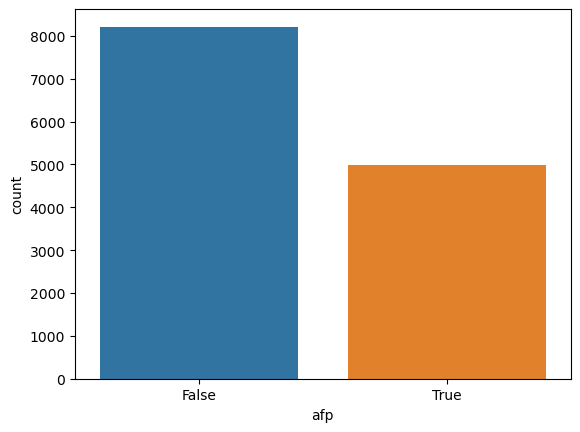

In [25]:
label_count = df_fsoir.value_counts('afp')
sns.barplot(x=label_count.index, y=label_count)

In [27]:
df_0 = df_fsoir[~df_fsoir['afp']]
df_1 = df_fsoir[df_fsoir['afp']]

min_sample = min(len(df_0),len(df_1))


df_0=df_0.sample(min_sample,random_state=_rs)
df_1=df_1.sample(min_sample,random_state=_rs)
df_ml = pd.concat([df_0,df_1])[['text','afp']]

df_ml

,text,afp
84800,"Coupe du Monde - matches des Bleus: quel jour,...",False
85065,"Mai 68, les barricades au Quartier latin (vidé...",False
84360,"""Ailleurs"": un sombre et singulier dessin anim...",False
50134,"Quand ""Le Monde"" déco...de\nTRIBUNE - Dr Maudr...",False
45096,"La Chine étend son emprise sur l'Europe, inves...",False
...,...,...
82631,"Bouteflika parti, les Algériens dans la rue po...",True
37582,Dutronc père et fils prêts à servir leur tourn...,True
65406,Vacances: des conseils simples pour limiter sa...,True
81973,"La grève et toujours pas de trêve, malgré l'ap...",True


# eli5 Text Explainer
---

## Preprocessing

In [28]:
import patat.util.text

In [29]:
import re

In [30]:
def preprocess(text):
    text = patat.util.text.preprocess(text)
    # Remove numbers
    text = re.sub(r'\d+','',text)
    return text

In [31]:
df_ml['text_p']=df_ml['text'].apply(preprocess)

## Reduction du nombre de paragraphes

In [32]:
nb_parags = 13
def cut_text(text):
    return '\n'.join(text.split('\n')[:nb_parags])

In [33]:
df_ml['text_ml']=df_ml['text_p'].apply(cut_text)

## Entrainement pipeline sur l'ensemble du corpus

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.pipeline import Pipeline, make_pipeline

In [35]:
#logreg = LogisticRegression(C=150, random_state=_rs, solver='lbfgs', multi_class='ovr', max_iter=1000)
logreg = LogisticRegression(C=150, random_state=_rs, max_iter=1000)

In [101]:
sw = stopwords[:120]+['afp','a','à']
#sw = stopwords

In [102]:
#vectorizer = TfidfVectorizer(stop_words=sw,ngram_range=(2,3))
vectorizer = TfidfVectorizer(stop_words=sw)

In [103]:
pipe = make_pipeline(vectorizer, logreg)

In [104]:
X = df_ml['text_p']
y = df_ml['afp']

## Crossvalidation

In [105]:
scores = cross_validate(pipe, X, y, cv=5,
                        scoring=('accuracy','f1','recall','roc_auc'))

In [106]:
df_scores=pd.DataFrame(scores)
df_scores

,fit_time,score_time,test_accuracy,test_f1,test_recall,test_roc_auc
0,2.668472,0.823562,0.927711,0.928642,0.940763,0.980357
1,3.170621,0.810776,0.939257,0.939104,0.936747,0.985230
2,2.383659,0.787030,0.941265,0.941993,0.953815,0.982488
3,2.521666,0.759287,0.942240,0.942871,0.953769,0.982529
4,3.410490,0.792002,0.938724,0.939424,0.949799,0.985563


In [107]:
df_scores.mean()

fit_time         2.830982
score_time       0.794531
test_accuracy    0.937839
test_f1          0.938407
test_recall      0.946979
test_roc_auc     0.983234
dtype: float64

<Figure size 800x600 with 0 Axes>

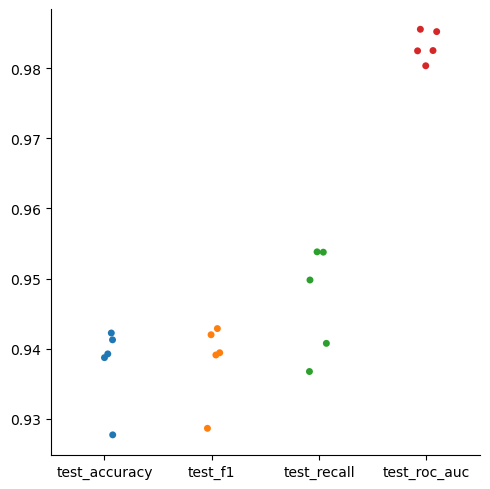

In [108]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.catplot(df_scores[['test_accuracy','test_f1','test_recall','test_roc_auc']])

## Entrainement sur tout le dataset

In [81]:
pipe.fit(X, y)
pipe.score(X, y)

1.0

In [82]:
import eli5
from eli5.lime import TextExplainer

In [83]:
df_weights = eli5.format_as_dataframe(eli5.explain_weights(logreg, vec=vectorizer, top=2000,
                   feature_names=vectorizer.get_feature_names_out()))

In [84]:
list(df_weights.loc[:200]['feature'])

['ajouté',
 'dit',
 'souligne',
 'indiqué',
 'estime',
 'mme',
 'an',
 'ajoute',
 'précisé',
 'souligné',
 'estimé',
 'affirmé',
 'annoncé',
 'dimanche',
 'poursuivi',
 'poursuit',
 'explique',
 'ça',
 'indique',
 'vendredi',
 'raconte',
 'lundi',
 'appris',
 'assure',
 'quelque',
 'communiqué',
 'etat',
 'ca',
 'affirme',
 'jeudi',
 'mercredi',
 'millions',
 'assuré',
 'chef',
 'tête',
 'etats',
 'ex',
 'quartier',
 'lr',
 'insisté',
 'auprès',
 'lancé',
 'centre',
 'salué',
 'nord',
 'gmt',
 'évoquant',
 'cour',
 'devant',
 'précise',
 'groupe',
 'parisienne',
 'national',
 'six',
 'parquet',
 'seine',
 'mardi',
 'dossier',
 'haute',
 'parmi',
 'sud',
 'britannique',
 'directeur',
 'note',
 'relève',
 'interrogé',
 'lance',
 'droite',
 'dix',
 'rappelle',
 'activité',
 'résume',
 'ndlr',
 'estimant',
 'orange',
 'environ',
 'fin',
 'observe',
 'américain',
 'gens',
 'seuil',
 'secrétaire',
 'familles',
 'attendus',
 'semaine',
 'ministre',
 'jugé',
 'maintien',
 'mondial',
 'insiste'

In [71]:
text = df_ml.sample(1).iloc[0]['text']
print(f'Score infox : {pipe.predict_proba([text])[:,1]}\n{text}')

Score infox : [0.99994711]
Cérémonie d'hommage national en mémoire de la policière tuée à Rambouillet
Une cérémonie d'hommage national présidée par le Premier ministre Jean Castex a débuté vendredi à Rambouillet (Yvelines) en mémoire de Stéphanie Monfermé, la fonctionnaire de police assassinée une semaine auparavant au sein du commissariat de la ville.
Un grand portrait en noir et blanc de Stéphanie Monfermé a été solennellement porté par des policiers, au début de la cérémonie, a constaté l'AFP.
Le chef du gouvernement doit prononcer un discours, dans la ville située à une soixantaine de kilomètres au sud-ouest de Paris, avant de remettre la légion d'honneur à titre posthume à l'agente administrative de 49 ans, mortellement poignardée le 23 avril.
Le porte-parole du gouvernement Gabriel Attal et cinq ministres assistent à la cérémonie: Gérald Darmanin (Intérieur), Eric Dupond-Moretti (Justice), Amélie de Montchalin (Fonction publique), Marlène Schiappa (Citoyenneté) et Nadia Hai (Vill

In [72]:
eli5.show_prediction(logreg, text,
                     vec=vectorizer,
                     feature_names=vectorizer.get_feature_names_out(),
                     target_names=['non_infox','infox'])

In [73]:
df_ml[df_ml['text_p'].str.contains(r'souligne')]['afp'].mean()

0.7550200803212851

In [58]:
df_weights.to_csv('data/tmp/infox_words.csv')

# Wordclouds

In [85]:
from wordcloud import WordCloud

In [88]:
text_afp = df_ml[df_ml['afp']]['text_p'].sum()

In [89]:
text_fsoir = df_ml[~df_ml['afp']]['text_p'].sum()

In [99]:
wordcloud = WordCloud(stopwords =sw,background_color="white").generate(text_afp)

(-0.5, 399.5, 199.5, -0.5)

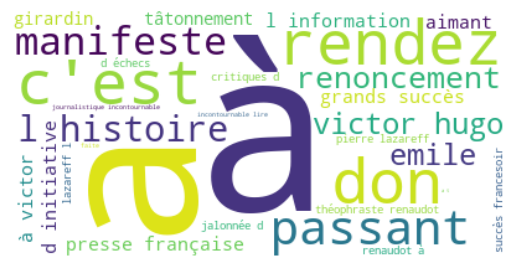

In [100]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

In [97]:
wordcloud = WordCloud(stopwords =sw).generate(text_fsoir)

(-0.5, 399.5, 199.5, -0.5)

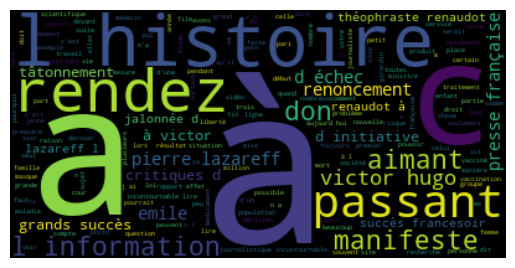

In [98]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")